### Creating the training model, testing it and refining it
We will create a baseline model using an ensemble estimator and then train it, test it and tune it to see how it performs

In [30]:
# global settings

# specify a data file path
data_location = "../data/"

# imports for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# further imports to go here
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
import time

In [31]:
# let's load it back in as a test...
train_file = "engineered_train.csv"

# specify columns for the training data as spanish is not a strong point in London
train_columns = ['ClientId','ClientName','ProductId','ProductName','ProductPieces','ProductWeight'
                 ,'SupplierCode','AgencyId','Town','State','WeekNumber','ChannelId','RouteId'
                 ,'Sales','SalesPesos','Returns','ReturnsPesos','Demand','Sales_L1','SalesPesos_L1'
                 ,'Returns_L1','ReturnsPesos_L1','Demand_L1','Sales_L2','SalesPesos_L2','Returns_L2','ReturnsPesos_L2'
                 ,'Demand_L2','Sales_L3','SalesPesos_L3','Returns_L3','ReturnsPesos_L3','Demand_L3']

# load the training data in full, skip the column headings on the first rows
t0 = time.time() 
df_train = pd.read_csv(data_location + train_file,names=train_columns,skiprows=1)
print 'loading complete in: ', time.time()-t0, ' seconds'

loading complete in:  4.3109998703  seconds


In [32]:
# start by dropping some features - mainly due to memory constraints when converting to encoded features!
new_train = df_train.drop(['AgencyId','ClientId','ProductId','ClientName','RouteId'],axis=1)

# now aggregate over the remaining categorical features
new_train = new_train.groupby(by=['ProductName','ProductPieces','ProductWeight','SupplierCode','WeekNumber',
                                    'State','Town','ChannelId'],as_index=False).sum()

print new_train.shape, df_train.shape

(20928, 28) (1078050, 33)


In [33]:
# now we have to create encoded features for the categorical features
vec = DictVectorizer()
    
vec_data = pd.DataFrame(vec.fit_transform(new_train[['ProductName','ProductPieces','ProductWeight','WeekNumber',
                                                       'State','Town','ChannelId','SupplierCode']]
                                          .to_dict(orient='records')).toarray())
vec_data.columns = vec.get_feature_names()
vec_data.index = new_train.index
    
new_train = new_train.drop(['ProductName','ProductPieces','ProductWeight',
                            'WeekNumber','State','Town','ChannelId','SupplierCode'], axis=1)
new_train = new_train.join(vec_data)

print new_train.shape

(20928, 471)


In [34]:
# now........let's hive off week 9 as the unseen set
df_unseen = new_train[new_train['WeekNumber']==9]
new_train = new_train[new_train['WeekNumber']!=9]

print df_unseen.shape
print new_train.shape

# let's separate new_train into X and y, drop 'this week's labels from X and put this week's label into y
X = new_train.drop(['Sales','Demand','Returns','SalesPesos','ReturnsPesos'],axis=1)
y = new_train['Demand']

# fill NaN values with 0 as this means there were no sales for that combination of categories
X = X.fillna(0)
y = y.fillna(0)

# split using a randomised split into 2/3 and 1/3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create a regression entity based on gradient boosting with initial params
reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=4, random_state=42, loss='ls')
print reg
t0 = time.time()

# fit to data
reg.fit(X_train, y_train)
t1 = time.time()

total = t1-t0
print total

(5346, 471)
(15582, 471)
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)
12.8239998817


In [36]:
# now predict using the model against the test data and calc rmse
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

# calculate benchmark error
benchmark = X_test['Demand_L1']
bmk = np.sqrt(mean_squared_error(y_test, benchmark))

# show the results
print 'The benchmark RMSE is {:.4f}. The model RMSE is {:.4f}'.format(bmk,rmse)

The benchmark RMSE is 328.9221. The model RMSE is 255.1222


In [37]:
# now let's try the unseen data...
Z_features = df_unseen.drop(['Sales','Demand','Returns','SalesPesos','ReturnsPesos'],axis=1)
z_label = df_unseen['Demand']

# fill NaN values
Z_features = Z_features.fillna(0)
z_label = z_label.fillna(0)

# try against the model
rmse = np.sqrt(mean_squared_error(z_label, reg.predict(Z_features)))

# calculate benchmark error
benchmark = Z_features['Demand_L1']
bmk = np.sqrt(mean_squared_error(z_label, benchmark))

# show the results
print 'The benchmark RMSE is {:.4f}. The model RMSE is {:.4f}'.format(bmk,rmse)

The benchmark RMSE is 489.9299. The model RMSE is 457.6523


In [8]:
# model importances
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Top 10 feature ranking:")

for f in range(10):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], X_train.columns.values[indices[f]]))

Top 10 feature ranking:
1. feature 0 (0.134999) Sales_L1
2. feature 4 (0.098192) Demand_L1
3. feature 10 (0.088241) Sales_L3
4. feature 5 (0.054889) Sales_L2
5. feature 14 (0.049364) Demand_L3
6. feature 1 (0.044503) SalesPesos_L1
7. feature 9 (0.037483) Demand_L2
8. feature 465 (0.028102) WeekNumber
9. feature 6 (0.026233) SalesPesos_L2
10. feature 2 (0.023454) Returns_L1


In [73]:
# let's tune the model...
# let's start to tune...
params = {'n_estimators':[50,100],'learning_rate' : [0.2,0.1,0.05],'max_depth':[4,6,8],'min_samples_split':[10,50,100]}

t0 = time.time()
gscv = GridSearchCV(reg,param_grid=params,cv=5)

gscv.fit(X_train,y_train)
t1 = time.time()

total = t1-t0
print total

print gscv.best_estimator_
print gscv.best_score_

3710.68099999
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.2, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=100,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)
0.918198261329


In [80]:
print gscv.score(X_test,y_test)
mse = np.sqrt(mean_squared_error(y_test, gscv.predict(X_test)))
print("RMSE: %.4f" % mse)

print gscv.score(Z_features,z_label)
mse = np.sqrt(mean_squared_error(z_label, gscv.predict(Z_features)))
print("RMSE: %.4f" % mse)

0.950434428693
RMSE: 253.6799
0.852927131218
RMSE: 459.0722


total demand was:  2119490.0
total demand predicted is:  2077583.3943
%age error is:  0.019772023319
count    5143.000000
mean       92.808163
std       237.665664
min         0.014828
25%        15.526179
50%        31.015358
75%        78.740412
max      4103.952811
Name: Demand, dtype: float64
count     5143.000000
mean       412.111608
std       1139.562663
min          0.000000
25%         23.000000
50%         96.000000
75%        360.000000
max      38512.000000
Name: Demand, dtype: float64


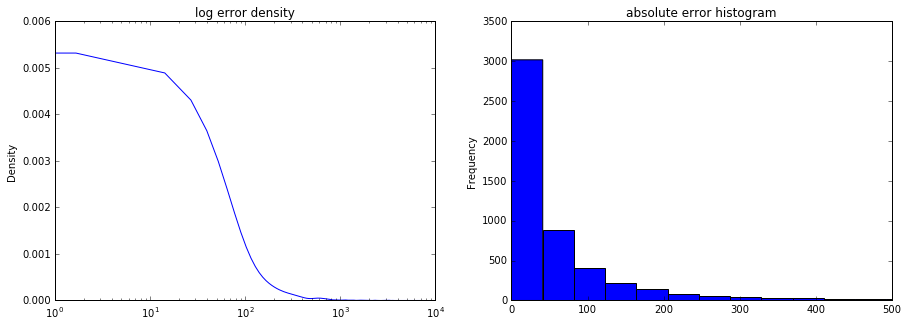

In [29]:
#let's plot a histogram of the errors
print 'total demand was: ', np.sum(y_test)
print 'total demand predicted is: ',np.sum(reg.predict(X_test))
print '%age error is: ',np.divide(np.subtract(np.sum(y_test),np.sum(reg.predict(X_test))),np.sum(y_test))
error = np.subtract(y_test, reg.predict(X_test))

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
error.plot(ax=axes[0],kind='kde',title='log error density',logx=True)

# and for absolute error
error = np.absolute(np.subtract(y_test, reg.predict(X_test)))
print error.describe()
print y_test.describe()
error.plot(ax=axes[1],kind='hist',bins=100,logx=False,title='absolute error histogram',xlim=(0,500))